# ⚡️ Energy Based Models

In this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the EBM](#build)
3. [Train the EBM](#train)
4. [Generate images](#generate)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn import datasets

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

from utils.image import display
from utils.datasets import sample_batch
import random

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = True

In [4]:
# Load the data
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

In [5]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs , ((0,0), (2,2), (2,2)), constant_values= -1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [6]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

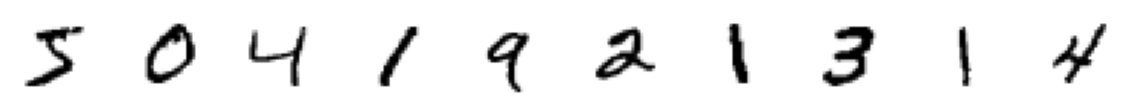

In [7]:
# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)

## 2. Build the EBM network <a name="train"></a>

In [8]:
ebm_input = keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = keras.layers.Conv2D(16, kernel_size=5, strides=2, padding="same", activation = keras.activations.swish)(ebm_input)
x = keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation = keras.activations.swish)(x)
x = keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation = keras.activations.swish)(x)
x = keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation = keras.activations.swish)(x)
x =  keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = keras.activations.swish)(x)
ebm_output = keras.layers.Dense(1)(x)
model = keras.Model(ebm_input, ebm_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

In [9]:
if LOAD_MODEL:
    model.load_weights('./models/model.h5')

## 2. Set up a Langevin sampler function <a name="sampler"></a>

In [10]:
# Function to generate samples using Langevin Dynamics
def generate_samples(model, inp_imgs, steps, step_size, noise, return_img_per_step=False):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean = 0, stddev = noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

## 3. Set up a buffer to store examples <a name="buffer"></a>

In [11]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [tf.random.uniform(shape = (1, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)) * 2 - 1 for _ in range(BATCH_SIZE)]
                         
    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        old_imgs = tf.concat(random.choices(self.examples, k=BATCH_SIZE-n_new), axis=0)
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size, noise = noise)
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis = 0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

In [12]:
class EBM(keras.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.reg_loss_metric = keras.metrics.Mean(name="reg")
        self.cdiv_loss_metric = keras.metrics.Mean(name="cdiv")
        self.real_out_metric = keras.metrics.Mean(name="real")
        self.fake_out_metric = keras.metrics.Mean(name="fake")
       
    @property
    def metrics(self):
        return [self.loss_metric, self.reg_loss_metric, self.cdiv_loss_metric, self.real_out_metric, self.fake_out_metric]
    
    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(shape=tf.shape(real_imgs), mean = 0, stddev = NOISE)
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(steps=STEPS, step_size=STEP_SIZE, noise = NOISE)
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis = 0) - tf.reduce_mean(real_out, axis = 0)
            reg_loss = self.alpha * tf.reduce_mean(real_out ** 2 + fake_out ** 2, axis = 0)
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis = 0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis = 0))
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis = 0) - tf.reduce_mean(real_out, axis = 0)
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis = 0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis = 0))
        return {m.name: m.result() for m in self.metrics[2:]}
        

In [13]:
ebm = EBM()

## 3. Train the EBM network <a name="train"></a>

In [14]:
# Compile and train the model
ebm.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True)

In [15]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

In [16]:
class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = np.random.uniform(size = (self.num_img,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)) * 2 - 1
        generated_images = generate_samples(ebm.model, start_imgs, steps=1000, step_size=STEP_SIZE, noise = NOISE, return_img_per_step=False)
        generated_images = generated_images.numpy()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        
        example_images = tf.concat(random.choices(ebm.buffer.examples, k = 10), axis = 0)
        example_images = example_images.numpy()
        display(example_images, save_to = "./output/example_img_%03d.png" % (epoch))

image_generator_callback = ImageGenerator(num_img=10)

In [17]:
class SaveModel(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        model.save_weights('./models/model.h5')
        
save_model_callback = SaveModel()

Epoch 1/60
469/469 [==============================] - ETA: 0s - loss: -0.0403 - reg: 0.0141 - cdiv: -0.0543 - real: 0.2235 - fake: 0.1691
Saved to ./output/generated_img_000.png


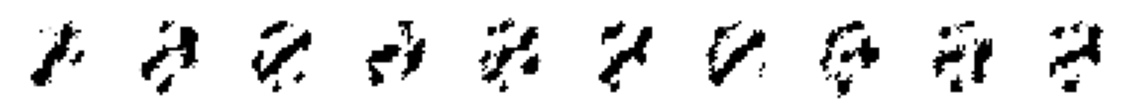


Saved to ./output/example_img_000.png


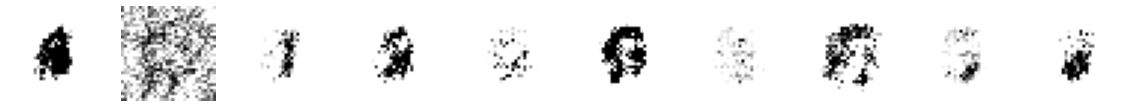

469/469 [==============================] - 300s 635ms/step - loss: -0.0403 - reg: 0.0141 - cdiv: -0.0543 - real: 0.2235 - fake: 0.1691 - val_cdiv: -1.4989 - val_real: 0.0031 - val_fake: -1.4958
Epoch 2/60
469/469 [==============================] - ETA: 0s - loss: -0.0033 - reg: 0.0023 - cdiv: -0.0056 - real: 0.0123 - fake: 0.0067
Saved to ./output/generated_img_001.png


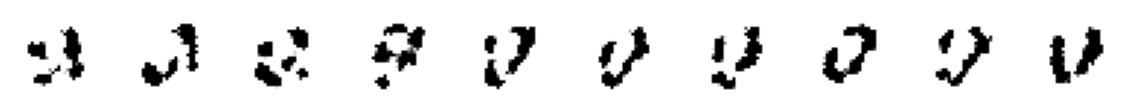


Saved to ./output/example_img_001.png


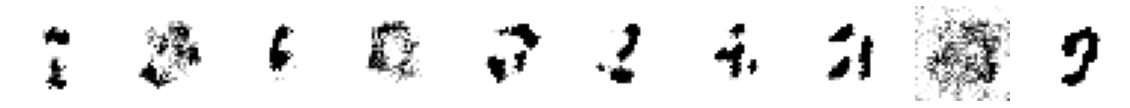

469/469 [==============================] - 292s 624ms/step - loss: -0.0033 - reg: 0.0023 - cdiv: -0.0056 - real: 0.0123 - fake: 0.0067 - val_cdiv: -1.7875 - val_real: -0.0588 - val_fake: -1.8463
Epoch 3/60
469/469 [==============================] - ETA: 0s - loss: -0.0011 - reg: 0.0013 - cdiv: -0.0024 - real: 0.0041 - fake: 0.0017
Saved to ./output/generated_img_002.png


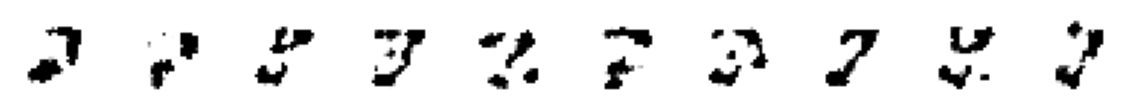


Saved to ./output/example_img_002.png


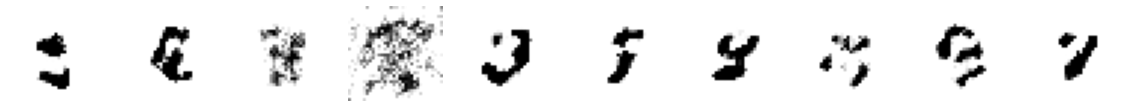

469/469 [==============================] - 292s 623ms/step - loss: -0.0011 - reg: 0.0013 - cdiv: -0.0024 - real: 0.0041 - fake: 0.0017 - val_cdiv: -2.0530 - val_real: -0.0630 - val_fake: -2.1160
Epoch 4/60
469/469 [==============================] - ETA: 0s - loss: -1.3210e-05 - reg: 6.5267e-04 - cdiv: -6.6588e-04 - real: 0.0022 - fake: 0.0015
Saved to ./output/generated_img_003.png


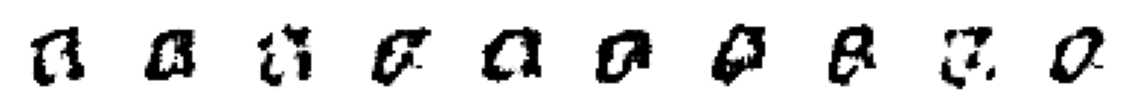


Saved to ./output/example_img_003.png


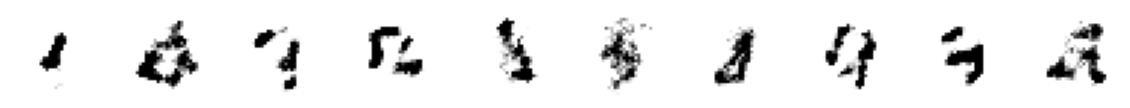

469/469 [==============================] - 290s 618ms/step - loss: -1.3210e-05 - reg: 6.5267e-04 - cdiv: -6.6588e-04 - real: 0.0022 - fake: 0.0015 - val_cdiv: -2.2771 - val_real: -0.0396 - val_fake: -2.3167
Epoch 5/60
469/469 [==============================] - ETA: 0s - loss: -1.2648e-05 - reg: 3.5331e-04 - cdiv: -3.6596e-04 - real: 0.0021 - fake: 0.0017
Saved to ./output/generated_img_004.png


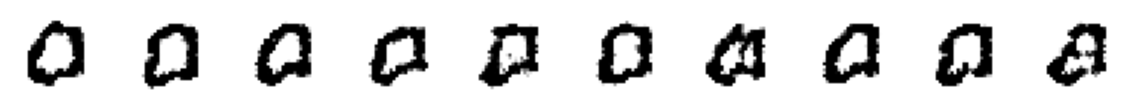


Saved to ./output/example_img_004.png


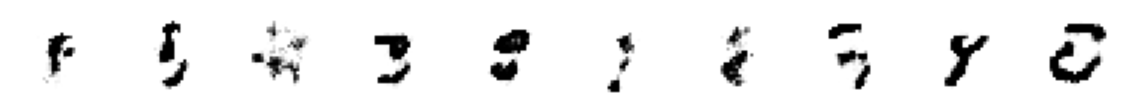

469/469 [==============================] - 289s 616ms/step - loss: -1.2648e-05 - reg: 3.5331e-04 - cdiv: -3.6596e-04 - real: 0.0021 - fake: 0.0017 - val_cdiv: -2.5345 - val_real: -0.0219 - val_fake: -2.5564
Epoch 6/60
469/469 [==============================] - ETA: 0s - loss: -2.6738e-04 - reg: 2.7160e-04 - cdiv: -5.3898e-04 - real: 0.0023 - fake: 0.0017
Saved to ./output/generated_img_005.png


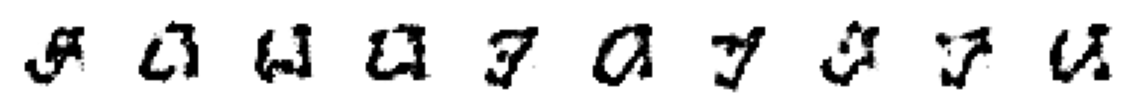


Saved to ./output/example_img_005.png


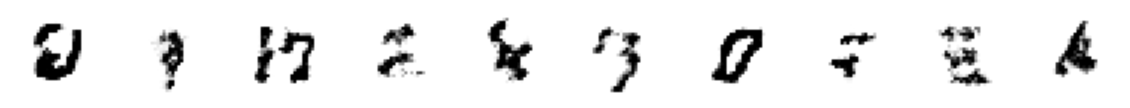

469/469 [==============================] - 289s 617ms/step - loss: -2.6738e-04 - reg: 2.7160e-04 - cdiv: -5.3898e-04 - real: 0.0023 - fake: 0.0017 - val_cdiv: -2.9512 - val_real: -0.0153 - val_fake: -2.9666
Epoch 7/60
469/469 [==============================] - ETA: 0s - loss: 5.7836e-04 - reg: 2.4815e-04 - cdiv: 3.3021e-04 - real: 9.0819e-04 - fake: 0.0012
Saved to ./output/generated_img_006.png


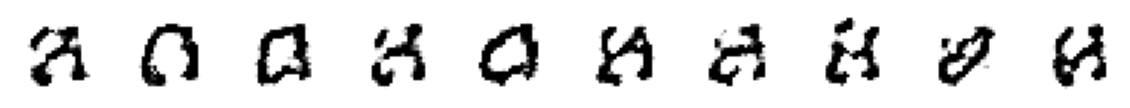


Saved to ./output/example_img_006.png


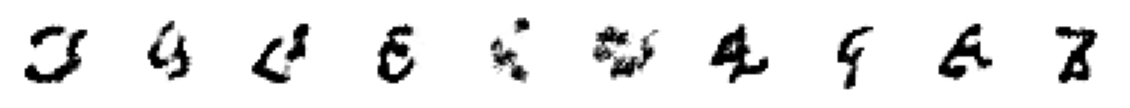

469/469 [==============================] - 289s 617ms/step - loss: 5.7836e-04 - reg: 2.4815e-04 - cdiv: 3.3021e-04 - real: 9.0819e-04 - fake: 0.0012 - val_cdiv: -3.1994 - val_real: -0.0095 - val_fake: -3.2089
Epoch 8/60
469/469 [==============================] - ETA: 0s - loss: 1.6249e-04 - reg: 2.9062e-04 - cdiv: -1.2813e-04 - real: 0.0015 - fake: 0.0013  
Saved to ./output/generated_img_007.png


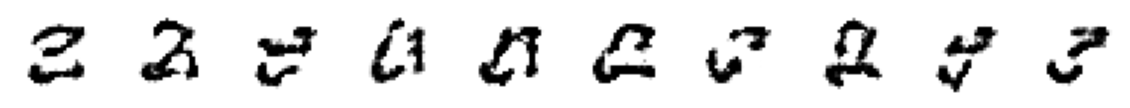


Saved to ./output/example_img_007.png


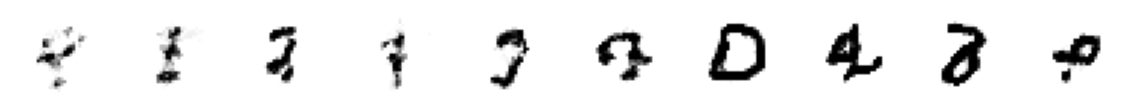

469/469 [==============================] - 289s 616ms/step - loss: 1.6249e-04 - reg: 2.9062e-04 - cdiv: -1.2813e-04 - real: 0.0015 - fake: 0.0013 - val_cdiv: -3.5961 - val_real: 0.0202 - val_fake: -3.5758
Epoch 9/60
469/469 [==============================] - ETA: 0s - loss: 1.1170e-04 - reg: 2.7895e-04 - cdiv: -1.6724e-04 - real: 0.0010 - fake: 8.8176e-04   
Saved to ./output/generated_img_008.png


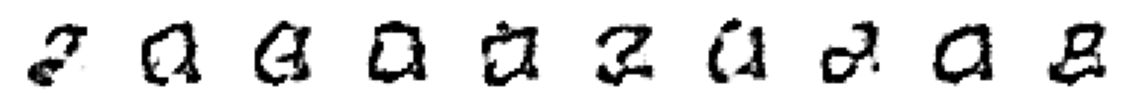


Saved to ./output/example_img_008.png


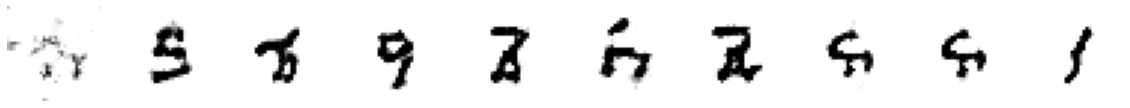

469/469 [==============================] - 289s 616ms/step - loss: 1.1170e-04 - reg: 2.7895e-04 - cdiv: -1.6724e-04 - real: 0.0010 - fake: 8.8176e-04 - val_cdiv: -3.9599 - val_real: 0.0186 - val_fake: -3.9413
Epoch 10/60
469/469 [==============================] - ETA: 0s - loss: -2.3854e-06 - reg: 3.2407e-04 - cdiv: -3.2645e-04 - real: 0.0016 - fake: 0.0013 
Saved to ./output/generated_img_009.png


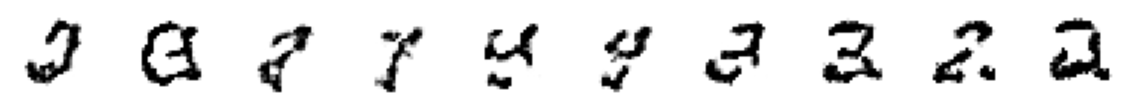


Saved to ./output/example_img_009.png


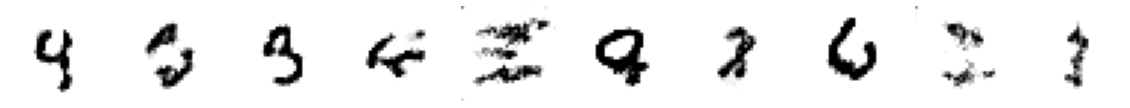

469/469 [==============================] - 285s 608ms/step - loss: -2.3854e-06 - reg: 3.2407e-04 - cdiv: -3.2645e-04 - real: 0.0016 - fake: 0.0013 - val_cdiv: -4.4635 - val_real: 0.0356 - val_fake: -4.4279
Epoch 11/60
469/469 [==============================] - ETA: 0s - loss: 1.3954e-04 - reg: 3.0668e-04 - cdiv: -1.6714e-04 - real: 9.1740e-04 - fake: 7.5026e-04
Saved to ./output/generated_img_010.png


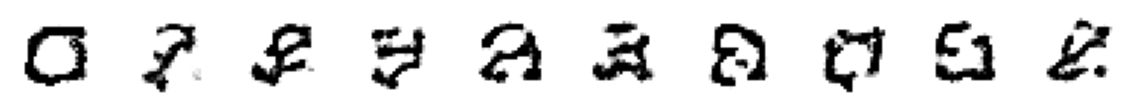


Saved to ./output/example_img_010.png


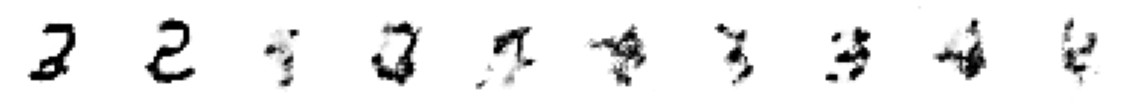

469/469 [==============================] - 282s 602ms/step - loss: 1.3954e-04 - reg: 3.0668e-04 - cdiv: -1.6714e-04 - real: 9.1740e-04 - fake: 7.5026e-04 - val_cdiv: -4.8353 - val_real: 0.0443 - val_fake: -4.7909
Epoch 12/60
469/469 [==============================] - ETA: 0s - loss: -2.8807e-04 - reg: 3.2889e-04 - cdiv: -6.1696e-04 - real: 8.5393e-04 - fake: 2.3697e-04
Saved to ./output/generated_img_011.png


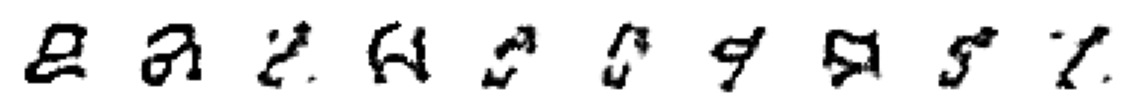


Saved to ./output/example_img_011.png


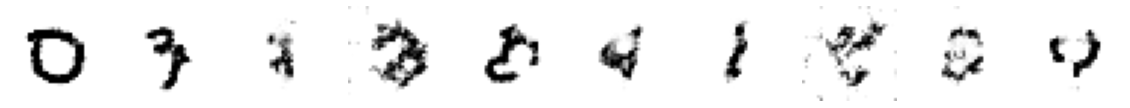

469/469 [==============================] - 280s 597ms/step - loss: -2.8807e-04 - reg: 3.2889e-04 - cdiv: -6.1696e-04 - real: 8.5393e-04 - fake: 2.3697e-04 - val_cdiv: -5.3021 - val_real: 0.0353 - val_fake: -5.2668
Epoch 13/60
469/469 [==============================] - ETA: 0s - loss: 8.4902e-05 - reg: 3.1361e-04 - cdiv: -2.2871e-04 - real: 0.0015 - fake: 0.0013  
Saved to ./output/generated_img_012.png


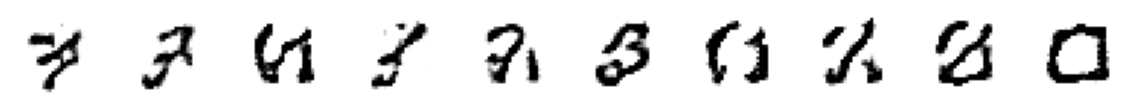


Saved to ./output/example_img_012.png


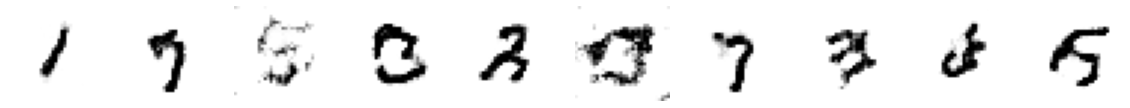

469/469 [==============================] - 274s 585ms/step - loss: 8.4902e-05 - reg: 3.1361e-04 - cdiv: -2.2871e-04 - real: 0.0015 - fake: 0.0013 - val_cdiv: -5.7038 - val_real: 0.0353 - val_fake: -5.6685
Epoch 14/60
469/469 [==============================] - ETA: 0s - loss: 2.7090e-04 - reg: 2.6418e-04 - cdiv: 6.7248e-06 - real: 9.0586e-04 - fake: 9.1258e-04
Saved to ./output/generated_img_013.png


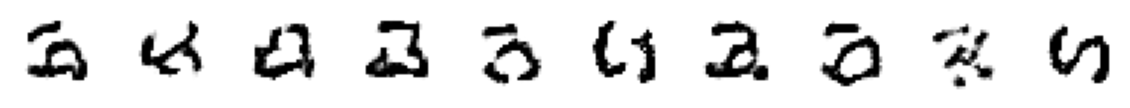


Saved to ./output/example_img_013.png


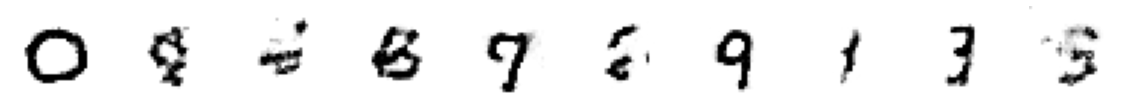

469/469 [==============================] - 275s 586ms/step - loss: 2.7090e-04 - reg: 2.6418e-04 - cdiv: 6.7248e-06 - real: 9.0586e-04 - fake: 9.1258e-04 - val_cdiv: -6.0369 - val_real: 0.0358 - val_fake: -6.0011
Epoch 15/60
469/469 [==============================] - ETA: 0s - loss: -8.0229e-05 - reg: 2.4958e-04 - cdiv: -3.2981e-04 - real: 5.4703e-04 - fake: 2.1722e-04
Saved to ./output/generated_img_014.png


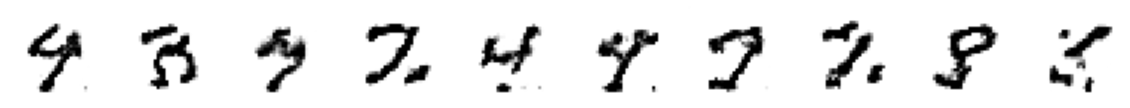


Saved to ./output/example_img_014.png


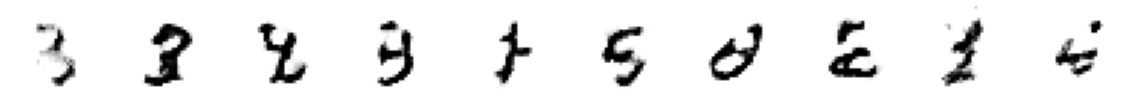

469/469 [==============================] - 275s 587ms/step - loss: -8.0229e-05 - reg: 2.4958e-04 - cdiv: -3.2981e-04 - real: 5.4703e-04 - fake: 2.1722e-04 - val_cdiv: -6.4531 - val_real: 0.0507 - val_fake: -6.4024
Epoch 16/60
469/469 [==============================] - ETA: 0s - loss: -2.7026e-04 - reg: 2.6889e-04 - cdiv: -5.3915e-04 - real: 9.6538e-04 - fake: 4.2624e-04
Saved to ./output/generated_img_015.png


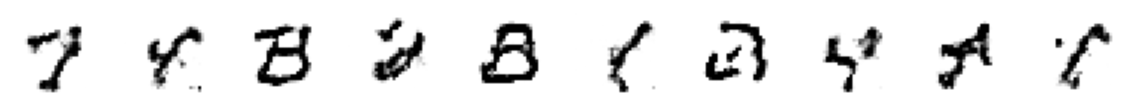


Saved to ./output/example_img_015.png


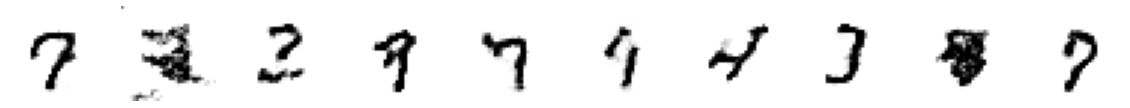

469/469 [==============================] - 273s 582ms/step - loss: -2.7026e-04 - reg: 2.6889e-04 - cdiv: -5.3915e-04 - real: 9.6538e-04 - fake: 4.2624e-04 - val_cdiv: -7.0066 - val_real: 0.0406 - val_fake: -6.9660
Epoch 17/60
469/469 [==============================] - ETA: 0s - loss: -6.4494e-05 - reg: 2.5783e-04 - cdiv: -3.2233e-04 - real: 6.0024e-04 - fake: 2.7791e-04
Saved to ./output/generated_img_016.png


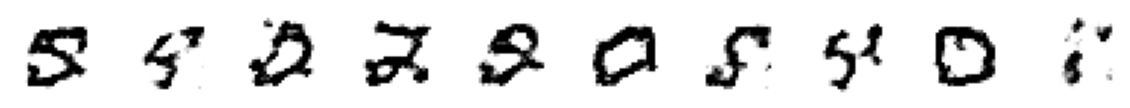


Saved to ./output/example_img_016.png


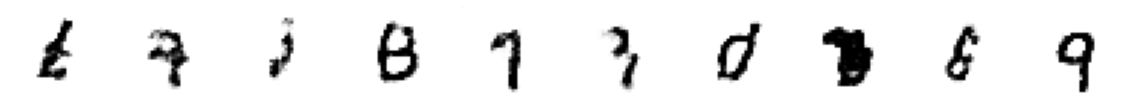

469/469 [==============================] - 275s 586ms/step - loss: -6.4494e-05 - reg: 2.5783e-04 - cdiv: -3.2233e-04 - real: 6.0024e-04 - fake: 2.7791e-04 - val_cdiv: -7.4209 - val_real: 0.0459 - val_fake: -7.3750
Epoch 18/60
469/469 [==============================] - ETA: 0s - loss: -1.3558e-04 - reg: 2.2742e-04 - cdiv: -3.6301e-04 - real: 0.0012 - fake: 8.7531e-04
Saved to ./output/generated_img_017.png


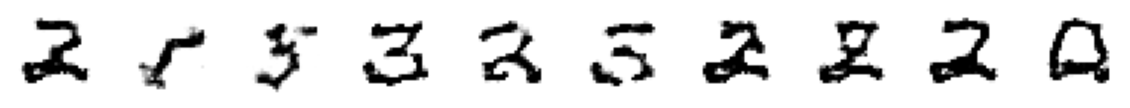


Saved to ./output/example_img_017.png


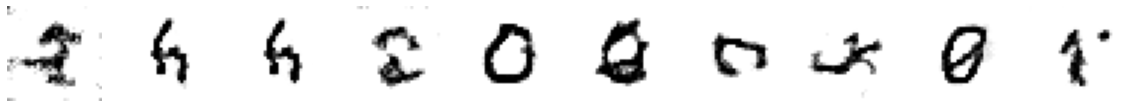

469/469 [==============================] - 273s 583ms/step - loss: -1.3558e-04 - reg: 2.2742e-04 - cdiv: -3.6301e-04 - real: 0.0012 - fake: 8.7531e-04 - val_cdiv: -7.9991 - val_real: 0.0301 - val_fake: -7.9690
Epoch 19/60
469/469 [==============================] - ETA: 0s - loss: 1.9898e-04 - reg: 2.7296e-04 - cdiv: -7.3976e-05 - real: 4.5025e-04 - fake: 3.7627e-04
Saved to ./output/generated_img_018.png


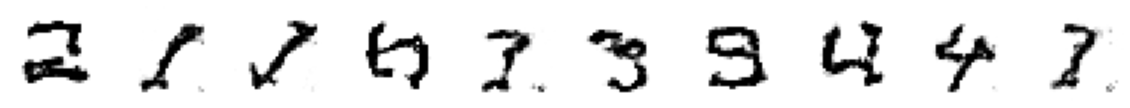


Saved to ./output/example_img_018.png


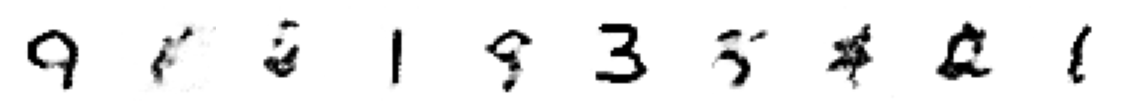

469/469 [==============================] - 275s 587ms/step - loss: 1.9898e-04 - reg: 2.7296e-04 - cdiv: -7.3976e-05 - real: 4.5025e-04 - fake: 3.7627e-04 - val_cdiv: -8.2410 - val_real: 0.0475 - val_fake: -8.1934
Epoch 20/60
469/469 [==============================] - ETA: 0s - loss: 7.8928e-05 - reg: 2.2123e-04 - cdiv: -1.4230e-04 - real: 5.0763e-04 - fake: 3.6534e-04
Saved to ./output/generated_img_019.png


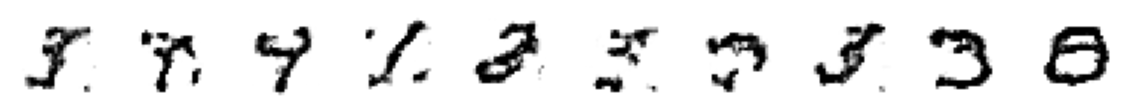


Saved to ./output/example_img_019.png


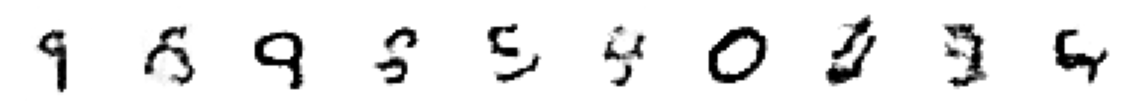

469/469 [==============================] - 273s 582ms/step - loss: 7.8928e-05 - reg: 2.2123e-04 - cdiv: -1.4230e-04 - real: 5.0763e-04 - fake: 3.6534e-04 - val_cdiv: -8.7669 - val_real: 0.0550 - val_fake: -8.7118
Epoch 21/60
469/469 [==============================] - ETA: 0s - loss: -6.5285e-05 - reg: 2.4697e-04 - cdiv: -3.1225e-04 - real: 8.1670e-04 - fake: 5.0444e-04
Saved to ./output/generated_img_020.png


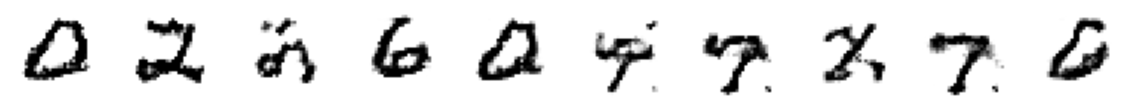


Saved to ./output/example_img_020.png


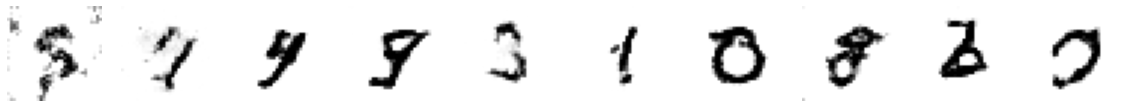

469/469 [==============================] - 274s 584ms/step - loss: -6.5285e-05 - reg: 2.4697e-04 - cdiv: -3.1225e-04 - real: 8.1670e-04 - fake: 5.0444e-04 - val_cdiv: -9.1531 - val_real: 0.0500 - val_fake: -9.1031
Epoch 22/60
469/469 [==============================] - ETA: 0s - loss: 7.6027e-05 - reg: 2.5259e-04 - cdiv: -1.7656e-04 - real: 7.9604e-04 - fake: 6.1947e-04
Saved to ./output/generated_img_021.png


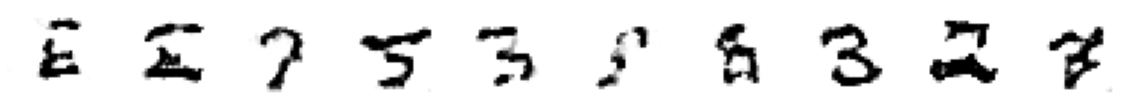


Saved to ./output/example_img_021.png


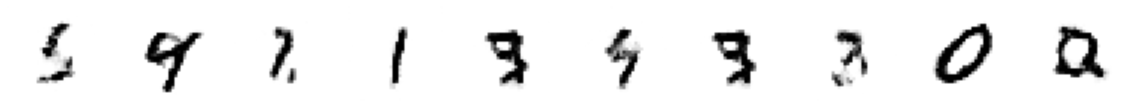

469/469 [==============================] - 274s 584ms/step - loss: 7.6027e-05 - reg: 2.5259e-04 - cdiv: -1.7656e-04 - real: 7.9604e-04 - fake: 6.1947e-04 - val_cdiv: -9.2924 - val_real: 0.0167 - val_fake: -9.2757
Epoch 23/60
469/469 [==============================] - ETA: 0s - loss: 1.4327e-04 - reg: 2.1060e-04 - cdiv: -6.7332e-05 - real: 6.9138e-04 - fake: 6.2405e-04
Saved to ./output/generated_img_022.png


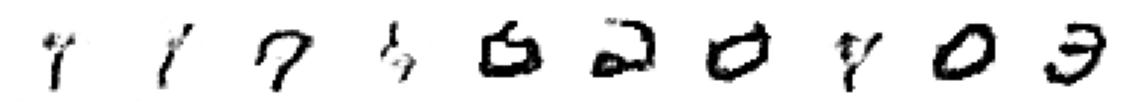


Saved to ./output/example_img_022.png


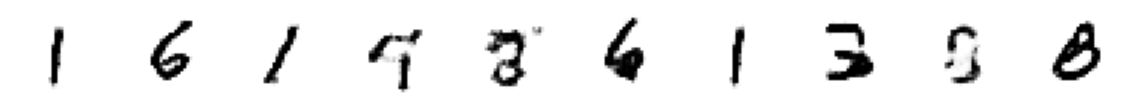

469/469 [==============================] - 273s 583ms/step - loss: 1.4327e-04 - reg: 2.1060e-04 - cdiv: -6.7332e-05 - real: 6.9138e-04 - fake: 6.2405e-04 - val_cdiv: -9.8430 - val_real: 0.0194 - val_fake: -9.8236
Epoch 24/60
469/469 [==============================] - ETA: 0s - loss: 9.6158e-05 - reg: 2.1387e-04 - cdiv: -1.1772e-04 - real: 5.6527e-04 - fake: 4.4755e-04
Saved to ./output/generated_img_023.png


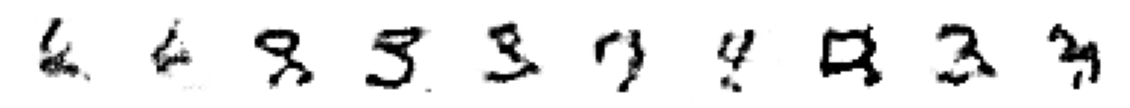


Saved to ./output/example_img_023.png


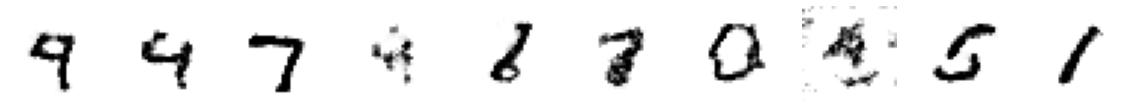

469/469 [==============================] - 275s 586ms/step - loss: 9.6158e-05 - reg: 2.1387e-04 - cdiv: -1.1772e-04 - real: 5.6527e-04 - fake: 4.4755e-04 - val_cdiv: -10.0280 - val_real: 0.0243 - val_fake: -10.0037
Epoch 25/60
469/469 [==============================] - ETA: 0s - loss: -2.2534e-05 - reg: 2.2239e-04 - cdiv: -2.4492e-04 - real: 6.1713e-04 - fake: 3.7221e-04
Saved to ./output/generated_img_024.png


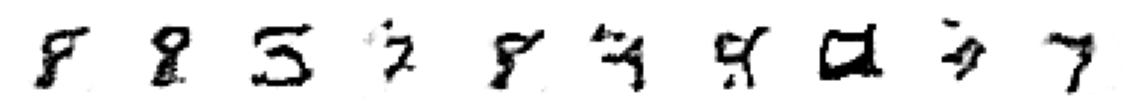


Saved to ./output/example_img_024.png


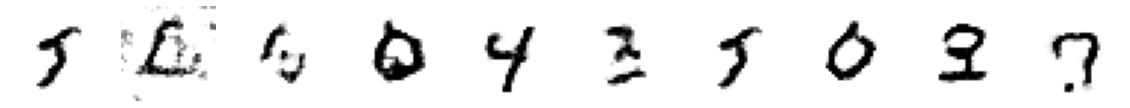

469/469 [==============================] - 274s 585ms/step - loss: -2.2534e-05 - reg: 2.2239e-04 - cdiv: -2.4492e-04 - real: 6.1713e-04 - fake: 3.7221e-04 - val_cdiv: -10.2988 - val_real: 0.0149 - val_fake: -10.2840
Epoch 26/60
469/469 [==============================] - ETA: 0s - loss: 5.5872e-05 - reg: 1.8811e-04 - cdiv: -1.3223e-04 - real: 7.3622e-04 - fake: 6.0399e-04
Saved to ./output/generated_img_025.png


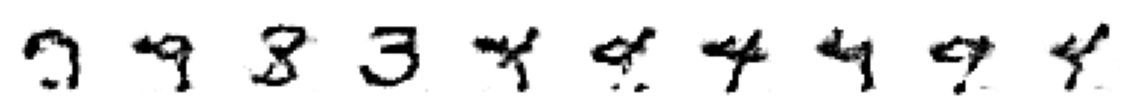


Saved to ./output/example_img_025.png


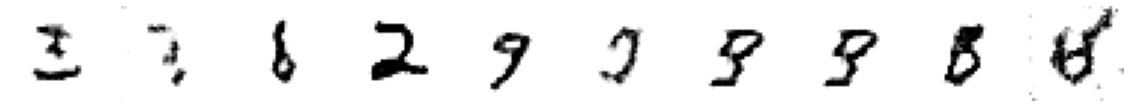

469/469 [==============================] - 274s 584ms/step - loss: 5.5872e-05 - reg: 1.8811e-04 - cdiv: -1.3223e-04 - real: 7.3622e-04 - fake: 6.0399e-04 - val_cdiv: -11.0103 - val_real: 0.0246 - val_fake: -10.9856
Epoch 27/60
469/469 [==============================] - ETA: 0s - loss: -3.1089e-05 - reg: 1.8035e-04 - cdiv: -2.1143e-04 - real: 6.4963e-04 - fake: 4.3820e-04
Saved to ./output/generated_img_026.png


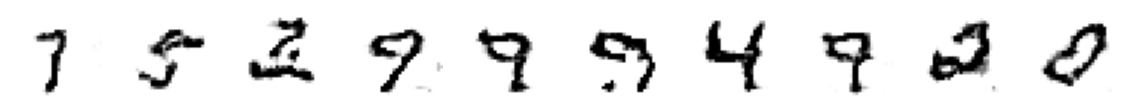


Saved to ./output/example_img_026.png


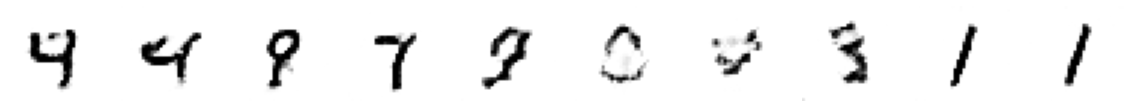

469/469 [==============================] - 273s 582ms/step - loss: -3.1089e-05 - reg: 1.8035e-04 - cdiv: -2.1143e-04 - real: 6.4963e-04 - fake: 4.3820e-04 - val_cdiv: -11.4831 - val_real: 0.0196 - val_fake: -11.4635
Epoch 28/60
469/469 [==============================] - ETA: 0s - loss: 1.1915e-04 - reg: 1.7424e-04 - cdiv: -5.5091e-05 - real: 3.9845e-04 - fake: 3.4335e-04
Saved to ./output/generated_img_027.png


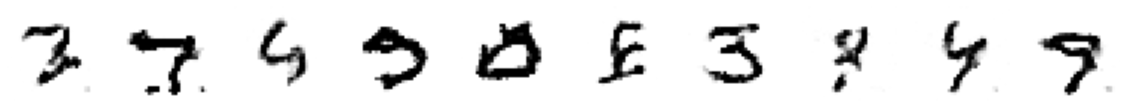


Saved to ./output/example_img_027.png


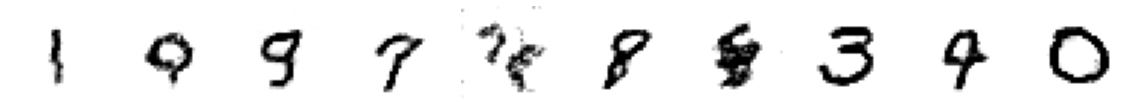

469/469 [==============================] - 275s 587ms/step - loss: 1.1915e-04 - reg: 1.7424e-04 - cdiv: -5.5091e-05 - real: 3.9845e-04 - fake: 3.4335e-04 - val_cdiv: -11.9917 - val_real: 0.0224 - val_fake: -11.9693
Epoch 29/60
469/469 [==============================] - ETA: 0s - loss: 4.4503e-05 - reg: 1.6391e-04 - cdiv: -1.1941e-04 - real: 4.5541e-04 - fake: 3.3601e-04
Saved to ./output/generated_img_028.png


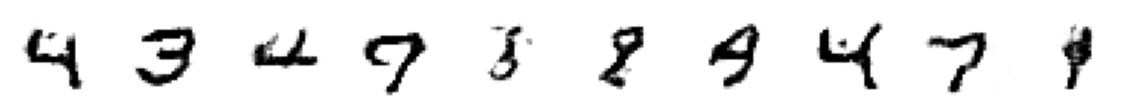


Saved to ./output/example_img_028.png


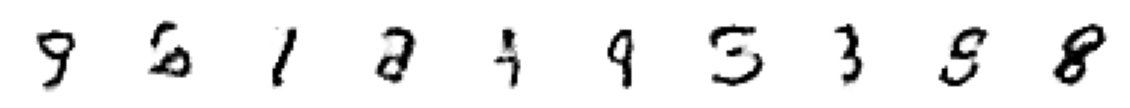

469/469 [==============================] - 276s 588ms/step - loss: 4.4503e-05 - reg: 1.6391e-04 - cdiv: -1.1941e-04 - real: 4.5541e-04 - fake: 3.3601e-04 - val_cdiv: -12.6810 - val_real: 0.0172 - val_fake: -12.6638
Epoch 30/60
469/469 [==============================] - ETA: 0s - loss: 1.2687e-04 - reg: 1.5629e-04 - cdiv: -2.9420e-05 - real: 6.2931e-04 - fake: 5.9989e-04
Saved to ./output/generated_img_029.png


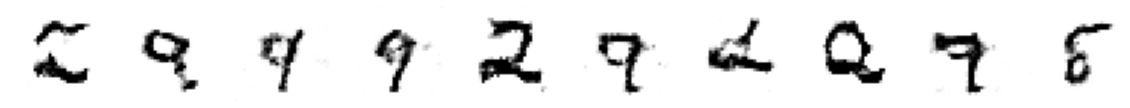


Saved to ./output/example_img_029.png


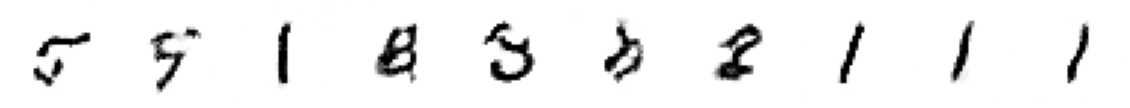

469/469 [==============================] - 273s 582ms/step - loss: 1.2687e-04 - reg: 1.5629e-04 - cdiv: -2.9420e-05 - real: 6.2931e-04 - fake: 5.9989e-04 - val_cdiv: -12.8456 - val_real: 0.0175 - val_fake: -12.8281
Epoch 31/60
469/469 [==============================] - ETA: 0s - loss: -5.9136e-05 - reg: 1.6274e-04 - cdiv: -2.2187e-04 - real: 7.2159e-04 - fake: 4.9971e-04
Saved to ./output/generated_img_030.png


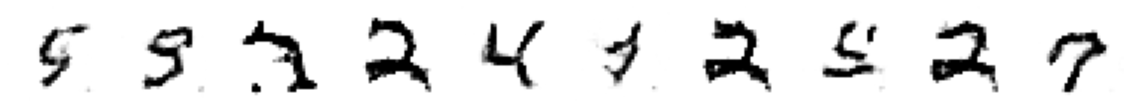


Saved to ./output/example_img_030.png


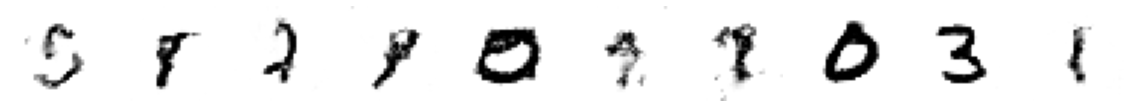

469/469 [==============================] - 275s 587ms/step - loss: -5.9136e-05 - reg: 1.6274e-04 - cdiv: -2.2187e-04 - real: 7.2159e-04 - fake: 4.9971e-04 - val_cdiv: -13.3269 - val_real: 0.0116 - val_fake: -13.3153
Epoch 32/60
469/469 [==============================] - ETA: 0s - loss: 3.0825e-05 - reg: 1.6299e-04 - cdiv: -1.3217e-04 - real: 2.4596e-04 - fake: 1.1379e-04
Saved to ./output/generated_img_031.png


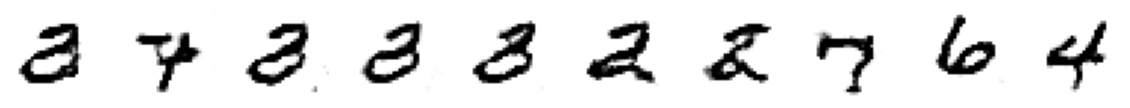


Saved to ./output/example_img_031.png


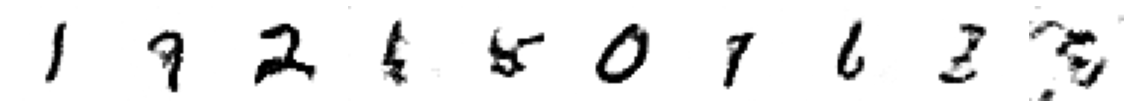

469/469 [==============================] - 273s 582ms/step - loss: 3.0825e-05 - reg: 1.6299e-04 - cdiv: -1.3217e-04 - real: 2.4596e-04 - fake: 1.1379e-04 - val_cdiv: -13.9455 - val_real: 0.0094 - val_fake: -13.9362
Epoch 33/60
116/469 [======>.......................] - ETA: 3:18 - loss: 3.2944e-04 - reg: 2.1109e-04 - cdiv: 1.1835e-04 - real: 0.0011 - fake: 0.0012        

In [ ]:
ebm.fit(
    # np.array([x_train[0] for _ in range(5000)] + [x_train[1] for _ in range(5000)])
    x_train
    , shuffle = True
    , epochs=60
    # , steps_per_epoch = 10
    # , initial_epoch = 39
    , validation_data = x_test
    , callbacks = [save_model_callback, tensorboard_callback, image_generator_callback]
)

## 4. Generate images <a name="generate"></a>

In [14]:
start_imgs = np.random.uniform(size = (10,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)) * 2 - 1

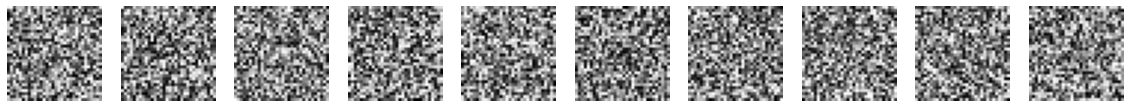

In [15]:
display(start_imgs)

In [18]:
gen_img = generate_samples(ebm.model, start_imgs, steps=1000, step_size=STEP_SIZE, noise = NOISE, return_img_per_step=True)

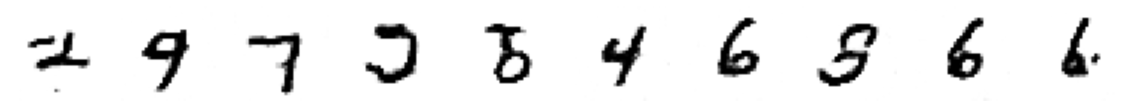

In [19]:
display(gen_img[-1].numpy())

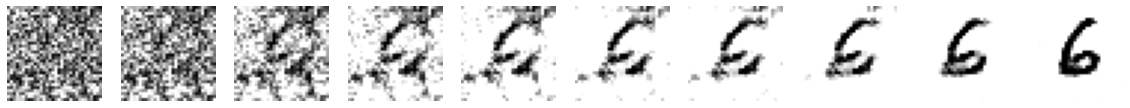

In [41]:
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])
    
display(np.array(imgs))